# <center> Assignment 2 - Computer Vision ENCS5343


### This assignment achieves to implement Content-Based Image Retrieval (CBIR) using various image representations in order to compare between them, observe the results of each technique and measure the efficiency of each technique using oereformance measures (Precision, Recall, AUC, F1-Score, ....)
#### Steps: 
1. Data processing (uploading images and getting them ready).
2. Prepare the functions of the techniques,
3. Choose an image representation technique.
4. Apply the CBIR on 15 different queries and measure the preformace using different measure metrics.
5. Observe the results depending with their rankings.
6. Compare between the techniques.

### Step 0: Import important packages and libraries.

In [9]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from sklearn.metrics import auc, roc_curve
from scipy.stats import kurtosis, mode
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity

### Step 1: Upload and store the data.

In [31]:
def upload_and_store_images(dataset_filepath):
    images = [] # List to contain all the PIL.Image objects

    # For loop to upload and store all the images that exist in the given directory
    # os.listdir: a method to load all the file/folder names inside a python list, sorted: built-in function to sort all the names depending on the ascii value
    for filename in sorted(os.listdir(path=dataset_filepath)): 
        # os.path.join: method to combine the directory path and the name of the file/folder in order to successfully load each image
        image_path = os.path.join(dataset_filepath, filename) 

        # If the current `filename` is actually a file
        if os.path.isfile(image_path):
            try: 
                # Try to open the file as an image
                images.append(Image.open(image_path))
            except:
                # Exception when the file is not an image or there is an error in the file 
                print("Failed to upload image: {image_path}")

    return images

images = upload_and_store_images('./dataset')



### Step 2: Prepare the functions of the techniques,

#### 1. Color Histograms

In [32]:
def calculate_color_histogram(images, number_of_bins):
    """
    Function to caulate the color histogram of all the images
    
    Parameters:
    -----------
    images (list): the list that contains all the images
    number_of_bins (int): number of bins to seperate the pixel values on in the histogram

    Returns:
    -----------
    histograms (ndarray): numpy array that contains all the histogram for each color channel (b, g, r) for each image
    """

    # Color channels
    color = ('b', 'g', 'r')

    # List that will contain all the histograms
    histograms = []

    # For loop to calculate the 3 histograms for each image
    for i in range(len(images)):

        # Initialize a list to contain the histograms for `images[i]`
        histograms.append([])

        # total_pixel variable to normalize the values of the histogram
        total_pixels = images[i].height * images[i].width

        # Copy the image in order to avoid any changes in the values
        img = np.array(images[i])[:, :, ::-1].copy()

        # For loop to iterate over the 3 color channels of `img`
        for j in range(len(color)):

            # Calculate the histogram for the `jth` channel and append it to the list of histograms of `img`
            histograms[-1].append(cv.calcHist([img], [j], None, [number_of_bins], [0,256]) / total_pixels)

    return np.array(histograms)

# Function to convert the distance into a probability
def distance_to_probability(distance):
    return np.exp(-distance)

def calculate_probabilities(index_query_image, images, features):
    """
    Function to calculate the probability of being similar to an image for all images
    
    Parameters:
    -----------
    images (list): the list that contains all the images
    features (list): list that contains all the features of all images
    index_query_image (int): the index of the query_image
    Returns:
    -----------
    probabilities (list): list that contains all the images, their probabilities and their classes
    """

    # List to contain all the probabilities of all images
    probabilities = []

    # For loop to iterate over all images
    for i, image in enumerate(images):

        # Calculate the distance between the features of the (query image) and the `ith` image
        distance = np.linalg.norm(features[index_query_image] - features[i])

        # Append the image, its probability and its class
        probabilities.append([image, distance_to_probability(distance), classes[i // 100]])
    
    # To sort the list using the value of the probability in order to have the most similar image on the top
    probabilities.sort(key=lambda x: x[1], reverse=True)
    
    return probabilities


#### 2. Color Moments

In [33]:
def calculate_moments(images, six_features,weights):
    """
    Function to calculate the color moments of all the images
    
    Parameters:
    -----------
    images (list): the list that contains all the images
    six_features (bool): a boolean to decide if we want to use 6 features instead of 3
    weights (list): a list that contains the corresponding weight for each feature

    Returns:
    -----------
    features (ndarray): numpy array that contains all the color moments of the three channels for all images
    """

    # To avoid errors
    if six_features and len(weights) == 3:
        weights += [1] * 3
    elif len(weights) < 3:
        weights += (3 - len(weights)) * [1]
    
    # To use the list of class labels 
    global classes

    # List that will contain all the color moments
    features = []

    # For loop to iterate over all images
    for i in range(len(images)):

        # Initialize a list to contain the moments for `images[i]`
        features.append([])

        # Copy the image in order to avoid any changes in the values
        image_np = np.array(images[i])[:, :, ::-1].copy()

        # For loop to iterate over the 3 color channels
        for j in range(3):

            # Take the 'jth` color channel to calculate the features for it
            data = image_np[:, :, j]

            # Calculate the 3 faetures
            mean = np.mean(data)
            std = np.std(data)
            skewness = np.mean((data - mean) ** 3) / (std ** 3) if std != 0 else 0

            # If we want to use 6 features
            if six_features == True:

                # Calculate the 3 other features
                median = np.median(data)
                kurtosis_measure = kurtosis(data, axis=None)
                mode_measure = mode(np.concatenate(data)).mode

                # Append the list of features to the features list of `images[i]`
                features[-1].append([mean * weights[0], std * weights[1], skewness * weights[2], mode_measure * weights[3], median * weights[4], kurtosis_measure * weights[5]])
            else:
                
                # Append the list of features to the features list of `images[i]`
                features[-1].append([weights[0] * mean, weights[1] * std, skewness * weights[2]])
    return np.array(features)


#### 3. Histogram of Oriented Gradients

In [34]:
def calculate_hogs(images):
    """
    Function to caculate the hogs of all images

    Parameters:
    -----------
    images (list): the list that contains all the images

    Returns:
    -----------
    features (ndarray): numpy array that contains all the HOG for each color channel (b, g, r) for each image
    """

    # To use the list of class labels
    global classes

    # List that will contain all the HOGs
    features = []

    # For loop to iterate over all the images
    for i in range(len(images)):

        # Initialize a list to contain the HOGs for `images[i]`
        features.append([])
        # Copy the image in order to avoid any changes in the values
        image_np = np.array(images[i])[:, :, ::-1].copy()

        # For loop to iterate over the 3 color channels
        for j in range(3):
            
            # Calculate the HOG for the `jth` channel and append it to the features list of the `ith` image
            features[-1].append([hog(image_np[:, :, j], orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')])
    return np.array(features)

# FUnction to comute the cosing similarity using `sklearn.metrics.pairwise.cosine_similarity` function
def compute_cosine_similarity(features1, features2):
    features1 = np.reshape(features1, (1, -1))
    features2 = np.reshape(features2, (1, -1))
    similarity = cosine_similarity(features1, features2)
    return similarity[0][0]


# Function to convert the similarity into probability in order to use in future calculations and decisions
def similarity_to_probability(similarity):
    return (similarity + 1) / 2



def calculate_probabilities_HOG(index_query_image, images, features):
    """
    Function to calculate the probability of being similar to an image for all images using HOG technique
    
    Parameters:
    -----------
    images (list): the list that contains all the images
    features (list): list that contains all the features of all images
    index_query_image (int): the index of the query_image
    Returns:
    -----------
    probabilities (list): list that contains all the images, their probabilities and their classes
    """

    # list to contain the probabilities of all the images for being similar to the image `images[index_query_image]`
    probabilities = []

    # For loop to iterate over all images
    for i, image in enumerate(images):

        # Comupte the similarity of the features of the query image and the features of the `ith` image
        similarity = compute_cosine_similarity(features[index_query_image], features[i])

        # Append the image, its probability and its class
        probabilities.append([image, similarity_to_probability(similarity), classes[i // 100]])

    # To sort the list using the value of the probability in order to have the most similar image on the top
    probabilities.sort(key=lambda x: x[1], reverse=True)
    return probabilities

#### General functions:

In [42]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def retrieve_similar_images(images, technique, bins=None, threshold=0.5,  six_features=None, weights=None):
    """
    Function to retrive the similar images to 15 random images using color histogram technique

    Parameters:
    -----------
    images (list): list of all images
    bins (int): number of bins in the histogram
    threshold (float): a threshold value to classify the similarity using it
    technique (str): the technique used to retrieve images
    six_features (bool): if the technique used is `moments` and we want to use 6 features instead of 3 then `True`
    weights (list): if the technique used is `moments` then we assign a value for each feature
    Returns:
    -----------
    query_images_idxs (list): list of the indexes of the 15 random images
    query_images_classes (list): list of the classes of the 15 random images
    query_images_similar_images (list): list of the images that are classified as similar
    query_images_similar_images_classes (list): the actual classes of the images that are classified as similar
    query_images_similar_images_probabilities (list): list of the probabilities of all the images that are classified as 
    """
    # To use the list of class labels 
    global classes
    # list to contain the indexes of the 15 random images
    query_images_idxs = []

    # list to contain the classes of the 15 random images
    query_images_classes = []

    # list to contain the images that are classified as similar
    query_images_similar_images = []

    # list to contain the classes of the images that are classified as similar
    query_images_similar_images_classes = []
    # list to contain the probabilities of the images that are classified as similar
    query_images_similar_images_probabilities = []

    # FOr loop to make 15 random images and get the similar images for them
    for i in range(15):
        
        # Generate a random index
        random_idx = np.random.randint(0, 1000)

        # Append that index into the indexes list
        query_images_idxs.append(random_idx)

        # Append the class of the 'ith' random image into the classes list
        query_images_classes.append(classes[random_idx // 100])

        # If the technique used is color histogram
        if technique == 'hist':
            if six_features or weights:
                print('Invalid parameters')
                return None
            # get the probabilities from the `calculate_probabilities` function and the `calculate_color_histogram` function
            probabilities = calculate_probabilities(random_idx, images, features=calculate_color_histogram(images, bins))

        # If the technique used is color moments    
        elif technique == 'moments':
            if bins:
                print('Invalid parameters')
                return None
            
            # get the probabilities from the `calculate_probabilities` function and the `calculate_moments` function
            probabilities = calculate_probabilities(random_idx, images, features=calculate_moments(images, weights=weights, six_features=six_features))

        # If the technique used is HOG
        elif technique == 'HOG':
            if six_features or weights or bins: 
                print('Invalid parameters')
                return None
            
            # get the probabilities from the `calculate_probabilities` function and the `calculate_hogs` function
            probabilities = calculate_probabilities_HOG(random_idx, images, features=calculate_hogs(images))
        
        # Append all the similar images into the `query_images_similar_images` list
        query_images_similar_images.append([probability[0] for probability in probabilities if probability[1] >= threshold])

        # Append the probabilities of all the similar images into the `query_images_similar_images` list
        query_images_similar_images_probabilities.append([probability[1] for probability in probabilities if probability[1] >= threshold])

        # Append the classes of all the similar images into the `query_images_similar_images` list
        query_images_similar_images_classes.append([probability[2] for probability in probabilities if probability[1] >= threshold])
    return query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities

# Function to compute the measures of performance
def compute_measures(query_image_class, retrieved_images_classes):
    true_positives = sum([1 for retrieved_image_class in retrieved_images_classes if retrieved_image_class == query_image_class])
    false_positives =  len(retrieved_images_classes) - true_positives
    false_negatives = 100 - true_positives
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 / ((1 / recall) + (1 / precision)) if (recall + precision) > 0 else 0
    return f1_score, precision, recall

# Function to show the results
def show_results(function_tuple):
    query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities = function_tuple
    f1_score = 0
    recall = 0
    precision = 0 
    true_labels = []
    predicted_probs = []
    for i in range(len(query_images_idxs)):
        f1_score_i, precision_i, recall_i = compute_measures(query_images_classes[i], query_images_similar_images_classes[i])
        f1_score += f1_score_i
        recall += recall_i
        precision += precision_i
        true_labels += [1 if label == query_images_classes[i] else 0 for label in query_images_similar_images_classes[i]]
        predicted_probs += query_images_similar_images_probabilities[i]
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    auc_measure = auc(fpr, tpr)
    print(f"F1-score: {f1_score / 15}")
    print(f"Recall score: {recall / 15}")
    print(f"Precision score: {precision / 15}")
    print(f"AUC: {auc_measure}")
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    query_image = images[query_images_idxs[0]]
    plt.figure(figsize=(20, 20))
    for i, image in enumerate([query_image] + query_images_similar_images[0][:9]):
        plt.subplot(1, 10, 1 + i)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

### Step 3: Choose an image representation technique.

#### A. Color Histogram

##### Theory: In image processing and photography, a color histogram is a representation of the distribution of colors in an image. For digital images, a color histogram represents the number of pixels that have colors in each of a fixed list of color ranges, that span the image's color space, the set of all possible colors. The color histogram can be built for any kind of color space, although the term is more often used for three-dimensional spaces such as RGB or HSV. For monochromatic images, the term intensity histogram may be used instead. For multi-spectral images, where each pixel is represented by an arbitrary number of measurements (for example, beyond the three measurements in RGB), the color histogram is N-dimensional, with N being the number of measurements taken. Each measurement has its own wavelength range of the light spectrum, some of which may be outside the visible spectrum.

For 120 bins: 

Time elapsed: 15.290788650512695
F1-score: 0.20670089454027607
Recall score: 0.47933333333333344
Precision score: 0.21110380532963985
AUC: 0.5768894990035462


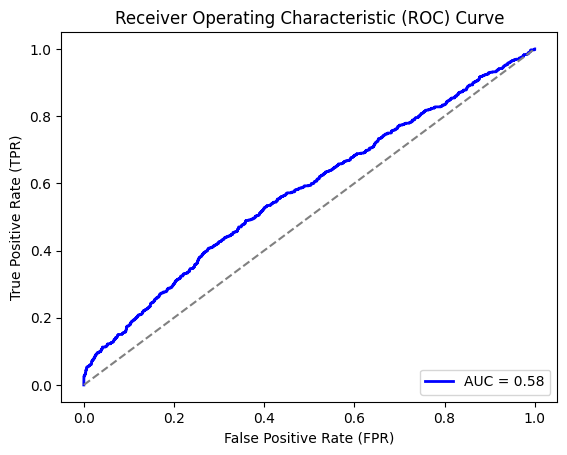

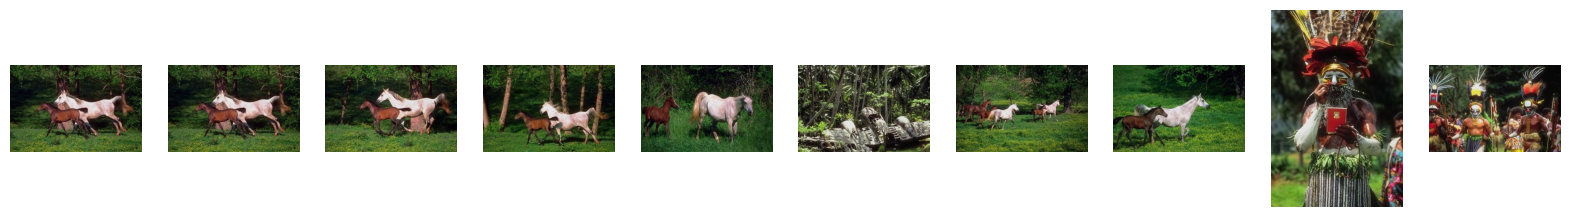

In [36]:
print("For 120 bins: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, bins=120, threshold=0.8, technique='hist')
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 180 bins: 

Time elapsed: 15.785895347595215
F1-score: 0.17005682559669058
Recall score: 0.5326666666666665
Precision score: 0.2645248611221026
AUC: 0.6009037387972247


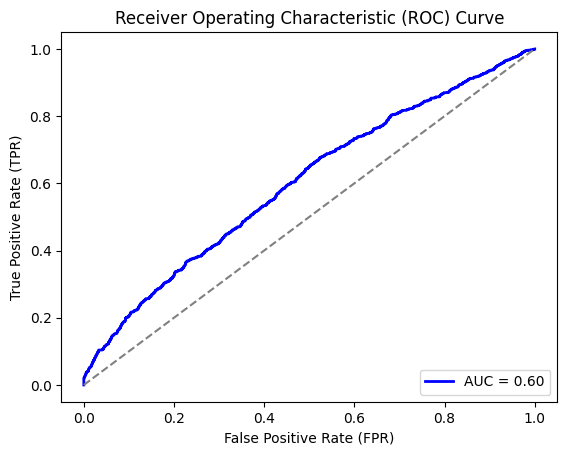

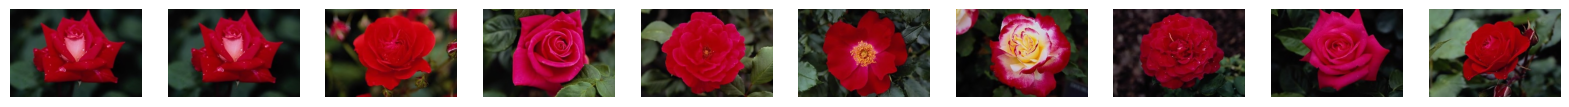

In [37]:
print("For 180 bins: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, bins=180, threshold=0.8, technique='hist')
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 360 bins: 

Time elapsed: 16.663461446762085
F1-score: 0.1517183316497483
Recall score: 0.5419999999999999
Precision score: 0.3817394626879855
AUC: 0.5333669167488021


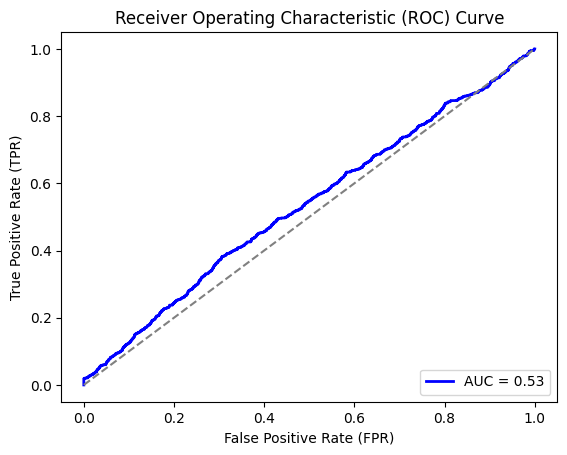

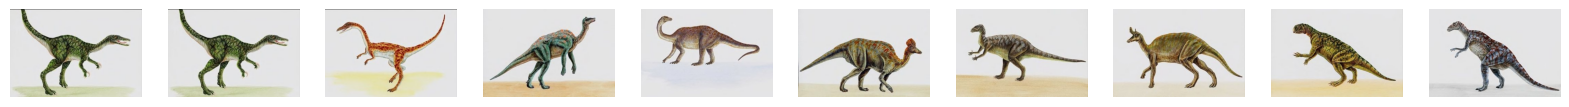

In [38]:
print("For 360 bins: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, bins=360, threshold=0.8, technique='hist')
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

#### B. Color moments

##### Theory: Color moments are measures that characterise color distribution in an image in the same way that central moments uniquely describe a probability distribution. Color moments are mainly used for color indexing purposes as features in image retrieval applications in order to compare how similar two images are based on color. Usually one image is compared to a database of digital images with pre-computed features in order to find and retrieve a similar Image. Each comparison between images results in a similarity score, and the lower this score is the more identical the two images are supposed to be.

For 3 unweighted features: 

Time elapsed: 152.86066126823425
F1-score: 0.029473064953554184
Recall score: 0.015333333333333336
Precision score: 0.9866666666666667
AUC: 0.8260869565217391


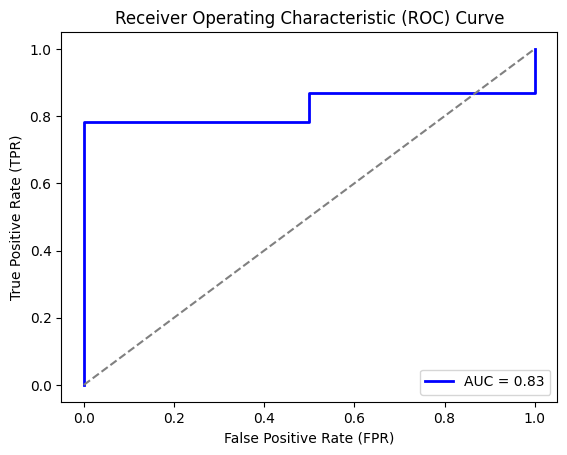

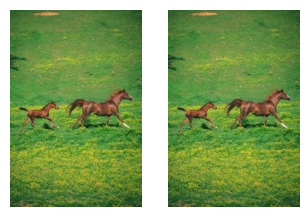

In [44]:
print("For 3 unweighted features: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, technique='moments',threshold=0.001, six_features=False, weights=[1, 1, 1])
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 3 weighted features: 

Time elapsed: 136.1491665840149
F1-score: 0.1337565932580019
Recall score: 0.08733333333333335
Precision score: 0.5062766598480883
AUC: 0.5858163014035951


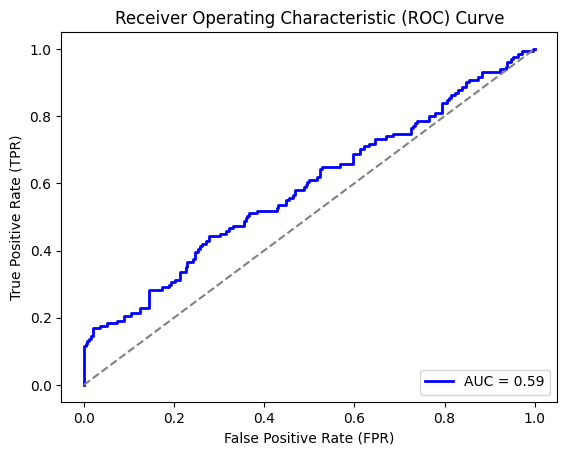

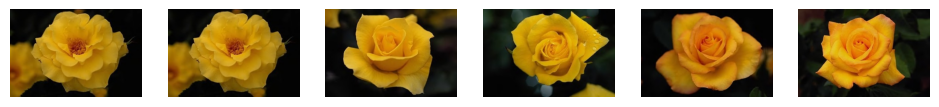

In [47]:
print("For 3 weighted features: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, technique='moments',threshold=0.001, six_features=False, weights=[0.25, 0.35, 0.4])
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

For 6 weighted features: 

Time elapsed: 502.0737295150757
F1-score: 0.21971797353448722
Recall score: 0.19333333333333336
Precision score: 0.3988103030652827
AUC: 0.6334613316949544


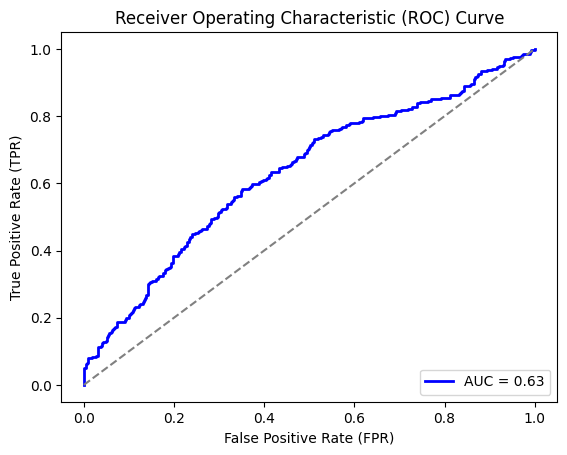

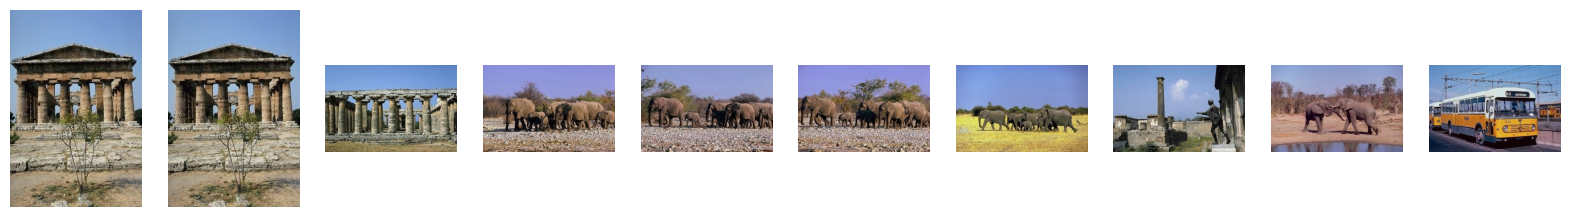

In [54]:
print("For 6 weighted features: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, technique='moments',threshold=0.001, six_features=True, weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

#### C. HOG

##### Theory: The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image. This method is similar to that of edge orientation histograms, scale-invariant feature transform descriptors, and shape contexts, but differs in that it is computed on a dense grid of uniformly spaced cells and uses overlapping local contrast normalization for improved accuracy.

Using HOG: 

Time elapsed: 1702.766359090805
F1-score: 0.031215930581822243
Recall score: 0.020666666666666673
Precision score: 0.9478632478632479
AUC: 0.6790058170280275


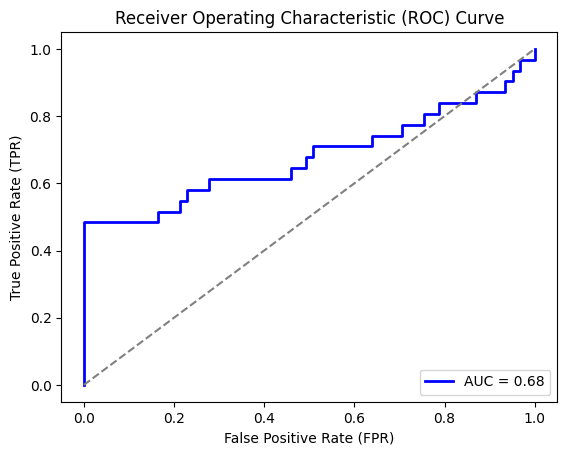

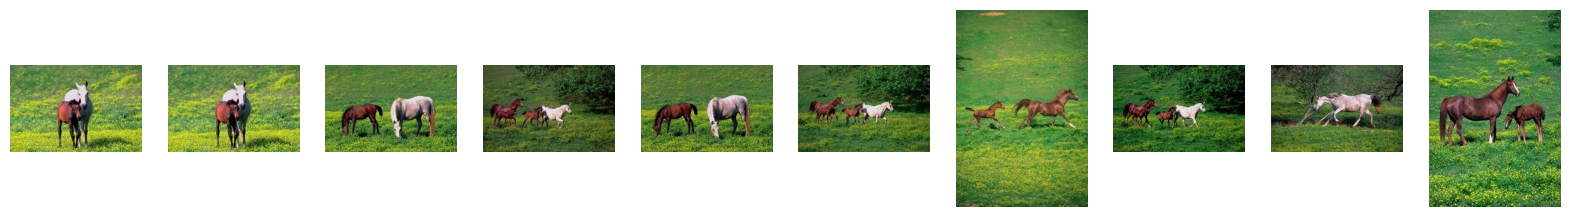

In [52]:
print("Using HOG: \n")
start_time = time.time()
function_tuple = retrieve_similar_images(images=images, threshold=0.9, technique='HOG')
end_time = time.time()
print(f"Time elapsed: {end_time - start_time}")
show_results(function_tuple)

### Results
* #### Out problem is a classification problem but since we are labeling the one class as `1` and all the other classes as `0`, it is an imbalanced classes classification problem.
* #### The best measures for classification problems (especially the ones with imbalanced classes) are the `recall` and the `precision`.  
* #### We will compare the time consumed in the caculations of each technique and the `average` of the preformance measures.
### Techniques:
1. ####  Color Histograms:
    * `120-bins`: Recall: 48%, Precision: 21%, F1-Score: 20.6%, AUC: 0.57, time: ~15.3 seconds.
    * `180-bins`: Recall: 53%, Precision: 26%, F1-Score: 17%, AUC: 0.60, time: ~15.7 seconds.
    * `360-bins`: Recall: 54%, Precision: 38%, F1-Score: 15%, AUC: 0.53, time: ~16.6 seconds.
2. #### Color Moments:
    * `3-unweighted features`: Recall: 1%, Precision: 98.6%, F1-Score: 2%, AUC: 0.82, time: ~153 seconds.
    * `3-weighted features`: Recall: 8%, Precision: 50%, F1-Score: 13%, AUC: 0.58, time: ~136 seconds.
    * `6-weighted features`: Recall: 54%, Precision: 38%, F1-Score: 15%, AUC: 0.53, time: ~502 seconds.
3. #### HOG:
    * Recall: 2%, Precision: 94.7%, F1-Score: 3%, AUC: 0.67, time: ~1702 seconds.

### Conclusion:
1. We could see that the recall and the precision in the Histograms are in general not bad, but this technique can't be used in real world CBIR problems because if the image was contiaining a blue horse (there is not blue horse in the real world) and an image of a brown horse, these two will not be classified as similar because this technique depends on the frequency of the pixels that can be fit in some range (determined using the bins hyperparameter). We used 120, 180 and 360 bins to represent the feature space, the one with 360 had the best results among them since it enables a larger range of feature space, but as we can conclude, we can't use this technique because it will underfit easily but it takes few seconds to make the caculations.

2. Color moments have good precision but bad recall because it depends on numerical features not on the place of the object(s), so if we had a picture of elephant on the left and another image of an elephant on the right they will not be classified as similar because of the (Sensitivity to Image Transformations). The time was higher than in Color Histograms. We saw from the observations above that if we assigned huge values to the weights, then the technique will overfit and only classify the image itself as similar even if we made the threshold low like `0.01`. In the last attempt on this technique we saw that if we make the weights lower then this technique could generalize better even if it was underfitting.

3. The HOG was good in the precision but very bad in the recall, this might happen because: Limited Texture Representation, Sensitivity to Image Variations, Dependency on Parameter Settings and other factors. This technique took a long time (approximately 30 minutes) to make all the calculations and that is very bad.


* We can conclude that the best technique in these three is the Color Moments (especially the one with the proper weights that are neither too large nor too small) since it does not underfit so much and does not overfit so much, its performance measures are good between all the 7 attempts and its time is not too high like 30 minutes.